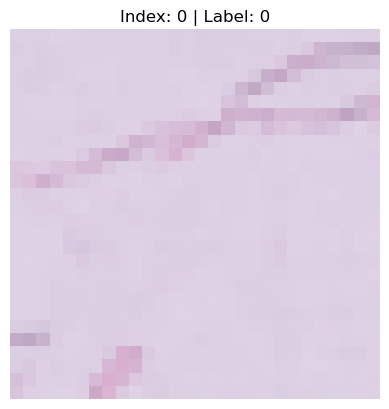

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = "/Users/arihangupta/.medmnist/pathmnist.npz"
data = np.load(file_path)

images = data["train_images"]
labels = data["train_labels"]

# Prepare figure
fig, ax = plt.subplots()
index = 0

def show_image(idx):
    ax.clear()
    img = images[idx]
    if img.ndim == 2:
        ax.imshow(img, cmap="gray")
    else:
        ax.imshow(img)
    ax.set_title(f"Index: {idx} | Label: {labels[idx][0]}")
    ax.axis("off")
    fig.canvas.draw()

# Initial display
show_image(index)

def on_key(event):
    global index
    if event.key == "right":
        index = (index + 1) % len(images)  # next image
    elif event.key == "left":
        index = (index - 1) % len(images)  # previous image
    show_image(index)

# Connect arrow keys
fig.canvas.mpl_connect("key_press_event", on_key)

plt.show()


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# -----------------
# Load MedMNIST subset (e.g. PathMNIST)
# -----------------
file_path = "/Users/arihangupta/.medmnist/pathmnist.npz"
data = np.load(file_path)

X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val, y_val     = data["val_images"], data["val_labels"].flatten()
X_test, y_test   = data["test_images"], data["test_labels"].flatten()

# Normalize
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

num_classes = len(np.unique(y_train))

# -----------------
# Build CNN model
# -----------------
def build_model(input_shape, num_classes, learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation="relu"),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# -----------------
# Training function
# -----------------
def train_model(epochs=10, batch_size=32, learning_rate=0.001):
    input_shape = X_train.shape[1:]  # (height, width, channels)
    model = build_model(input_shape, num_classes, learning_rate)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"\n✅ Test Accuracy: {test_acc:.4f}")

    return model, history

# -----------------
# Example usage
# -----------------
# Control parameters here
model, history = train_model(
    epochs=5,         # change epochs
    batch_size=64,    # change batch size
    learning_rate=1e-3
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.6054 - loss: 1.0542 - val_accuracy: 0.6836 - val_loss: 0.8660
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.7312 - loss: 0.7310 - val_accuracy: 0.7175 - val_loss: 0.7945
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.7745 - loss: 0.6189 - val_accuracy: 0.7684 - val_loss: 0.6426
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.8000 - loss: 0.5467 - val_accuracy: 0.7706 - val_loss: 0.6438
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.8220 - loss: 0.4857 - val_accuracy: 0.8208 - val_loss: 0.4824
225/225 - 1s - 5ms/step - accuracy: 0.7460 - loss: 0.7622

✅ Test Accuracy: 0.7460


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# -----------------
# Load MedMNIST subset (PathMNIST example)
# -----------------
file_path = "/Users/arihangupta/.medmnist/pathmnist.npz"
data = np.load(file_path)

X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val, y_val     = data["val_images"], data["val_labels"].flatten()
X_test, y_test   = data["test_images"], data["test_labels"].flatten()

# -----------------
# Preprocess (normalize, expand to 3 channels if grayscale)
# -----------------
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

if X_train.ndim == 3 or X_train.shape[-1] == 1:
    X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
    X_val   = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
    X_test  = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

num_classes = len(np.unique(y_train))

# -----------------
# Data pipeline (resize on the fly instead of all at once)
# -----------------
IMG_SIZE = 224

def make_dataset(images, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, batch_size=32, shuffle=True)
val_ds   = make_dataset(X_val, y_val, batch_size=32, shuffle=False)
test_ds  = make_dataset(X_test, y_test, batch_size=32, shuffle=False)

# -----------------
# Build ResNet50 model
# -----------------
def build_resnet(input_shape, num_classes, learning_rate=1e-4):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    base_model.trainable = False  # freeze backbone

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# -----------------
# Training function
# -----------------
def train_resnet(epochs=5, batch_size=32, learning_rate=1e-4):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    model = build_resnet(input_shape, num_classes, learning_rate)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print(f"\n🎯 Final Test Accuracy (ResNet50): {test_acc:.4f}")

    return model, history

# -----------------
# Example usage
# -----------------
model, history = train_resnet(
    epochs=3,
    batch_size=32,
    learning_rate=1e-4
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2982s 1s/step - accuracy: 0.1692 - loss: 2.1729 - val_accuracy: 0.2137 - val_loss: 2.1123
Epoch 2/3
1224/2813 ━━━━━━━━━━━━━━━━━━━━ 24:35 929ms/step - accuracy: 0.2127 - loss: 2.1092

KeyboardInterrupt: 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# -----------------
# Load MedMNIST subset (PathMNIST example)
# -----------------
file_path = "/Users/arihangupta/.medmnist/pathmnist.npz"
data = np.load(file_path)

X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val, y_val     = data["val_images"], data["val_labels"].flatten()
X_test, y_test   = data["test_images"], data["test_labels"].flatten()

# -----------------
# Preprocess (normalize, expand grayscale → 3 channels if needed)
# -----------------
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

if X_train.ndim == 3 or X_train.shape[-1] == 1:
    X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
    X_val   = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
    X_test  = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

num_classes = len(np.unique(y_train))

# -----------------
# Data pipeline (resize small → 64x64 for speed)
# -----------------
IMG_SIZE = 64

def make_dataset(images, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, batch_size=32, shuffle=True)
val_ds   = make_dataset(X_val, y_val, batch_size=32, shuffle=False)
test_ds  = make_dataset(X_test, y_test, batch_size=32, shuffle=False)

# -----------------
# Build a lightweight CNN
# -----------------
def build_cnn(input_shape, num_classes, learning_rate=1e-3):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# -----------------
# Training progress callback
# -----------------
class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, "
              f"val_acc={logs['val_accuracy']:.4f}")

# -----------------
# Manual unstructured pruning
# -----------------
def prune_weights(model, threshold=0.01):
    """
    Zero out weights with magnitude below threshold.
    Applies to Conv2D and Dense layers.
    """
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

# -----------------
# Train, prune, save, evaluate
# -----------------
def train_and_prune(epochs=5, learning_rate=1e-3, pruning_threshold=0.01, fine_tune_epochs=2):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)

    # --- Train base CNN ---
    print("\n🚀 Training base CNN...")
    model = build_cnn(input_shape, num_classes, learning_rate)
    model.fit(train_ds, validation_data=val_ds,
              epochs=epochs, callbacks=[TrainingProgress()], verbose=0)

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\n🎯 Test Accuracy (Unpruned CNN): {test_acc:.4f}")

    # Save base model
    os.makedirs("saved_models", exist_ok=True)
    unpruned_path = "saved_models/cnn_unpruned.h5"
    model.save(unpruned_path)
    print(f"💾 Saved unpruned model as {unpruned_path}")

    # --- Manual pruning ---
    print(f"\n✂️ Applying manual pruning (threshold={pruning_threshold})...")
    pruned_model = prune_weights(model, threshold=pruning_threshold)

    # Optional fine-tune after pruning
    if fine_tune_epochs > 0:
        print(f"🛠 Fine-tuning pruned model for {fine_tune_epochs} epochs...")
        pruned_model.fit(train_ds, validation_data=val_ds,
                         epochs=fine_tune_epochs, callbacks=[TrainingProgress()], verbose=0)

    test_loss, test_acc = pruned_model.evaluate(test_ds, verbose=0)
    print(f"\n🎯 Test Accuracy (Pruned CNN): {test_acc:.4f}")

    pruned_path = "saved_models/cnn_pruned.h5"
    pruned_model.save(pruned_path)
    print(f"💾 Saved pruned model as {pruned_path}")

    return model, pruned_model

# -----------------
# Run
# -----------------
base_model, pruned_model = train_and_prune(
    epochs=5,
    learning_rate=1e-3,
    pruning_threshold=0.01,
    fine_tune_epochs=2
)



🚀 Training base CNN...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Epoch 1: loss=1.2787, val_loss=0.9539, acc=0.5220, val_acc=0.6373
✅ Epoch 2: loss=0.8517, val_loss=0.6645, acc=0.6932, val_acc=0.7542
✅ Epoch 3: loss=0.6919, val_loss=0.5030, acc=0.7537, val_acc=0.8132
✅ Epoch 4: loss=0.5998, val_loss=0.4450, acc=0.7865, val_acc=0.8360
✅ Epoch 5: loss=0.5211, val_loss=0.4386, acc=0.8149, val_acc=0.8398



🎯 Test Accuracy (Unpruned CNN): 0.7898
💾 Saved unpruned model as saved_models/cnn_unpruned.h5

✂️ Applying manual pruning (threshold=0.01)...
🛠 Fine-tuning pruned model for 2 epochs...
✅ Epoch 1: loss=0.4671, val_loss=0.4288, acc=0.8339, val_acc=0.8450
✅ Epoch 2: loss=0.4282, val_loss=0.3771, acc=0.8475, val_acc=0.8692



🎯 Test Accuracy (Pruned CNN): 0.8070
💾 Saved pruned model as saved_models/cnn_pruned.h5


In [4]:
import os

def print_model_sizes(unpruned_path, pruned_path):
    size_unpruned = os.path.getsize(unpruned_path) / (1024*1024)
    size_pruned   = os.path.getsize(pruned_path) / (1024*1024)
    print(f"📦 Unpruned model size: {size_unpruned:.2f} MB")
    print(f"📦 Pruned model size:   {size_pruned:.2f} MB")

unpruned_path = "saved_models/cnn_unpruned.h5"
pruned_path   = "saved_models/cnn_pruned.h5"

print_model_sizes(unpruned_path, pruned_path)


📦 Unpruned model size: 7.88 MB
📦 Pruned model size:   7.88 MB


In [5]:
import tensorflow as tf
import time
import os
import numpy as np

# -----------------
# Paths to saved models
# -----------------
unpruned_path = "saved_models/cnn_unpruned.h5"
pruned_path   = "saved_models/cnn_pruned.h5"

# -----------------
# Load test dataset
# -----------------
file_path = "/Users/arihangupta/.medmnist/pathmnist.npz"
data = np.load(file_path)
X_test, y_test = data["test_images"], data["test_labels"].flatten()

# Normalize
X_test = X_test.astype("float32") / 255.0

# Expand grayscale → 3 channels if needed
if X_test.ndim == 3 or X_test.shape[-1] == 1:
    X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Resize to 64x64
IMG_SIZE = 64
X_test_resized = np.array([tf.image.resize(img, [IMG_SIZE, IMG_SIZE]).numpy() for img in X_test])

# Prepare dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test_resized, y_test)).batch(32)

# -----------------
# Load models
# -----------------
print("Loading models...")
unpruned_model = tf.keras.models.load_model(unpruned_path)
pruned_model   = tf.keras.models.load_model(pruned_path)

# -----------------
# Measure inference speed
# -----------------
def measure_inference_speed(model, dataset, name="Model"):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    end = time.time()
    print(f"⏱ {name} inference time on test set: {end - start:.4f} seconds")

print("\nMeasuring inference speed on test set...")
measure_inference_speed(unpruned_model, test_ds, name="Unpruned CNN")
measure_inference_speed(pruned_model, test_ds, name="Pruned CNN")


Loading models...

Measuring inference speed on test set...
⏱ Unpruned CNN inference time on test set: 3.0476 seconds
⏱ Pruned CNN inference time on test set: 2.6050 seconds


In [6]:
import tensorflow as tf
import numpy as np

# Paths to saved models
unpruned_path = "saved_models/cnn_unpruned.h5"
pruned_path   = "saved_models/cnn_pruned.h5"

# Load models
unpruned_model = tf.keras.models.load_model(unpruned_path)
pruned_model   = tf.keras.models.load_model(pruned_path)

# Function to count zero weights
def count_zero_weights(model):
    total_weights = 0
    zero_weights = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            total_weights += w.size + b.size
            zero_weights += np.sum(w == 0) + np.sum(b == 0)
    return zero_weights, total_weights

# Count zeroed weights
zero_unpruned, total_unpruned = count_zero_weights(unpruned_model)
zero_pruned, total_pruned     = count_zero_weights(pruned_model)

# Print results
print(f"📦 Unpruned model: {zero_unpruned}/{total_unpruned} weights are zero "
      f"({zero_unpruned/total_unpruned*100:.2f}%)")
print(f"📦 Pruned model:   {zero_pruned}/{total_pruned} weights are zero "
      f"({zero_pruned/total_pruned*100:.2f}%)")


📦 Unpruned model: 0/684361 weights are zero (0.00%)
📦 Pruned model:   123003/684361 weights are zero (17.97%)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import time

# -----------------
# Load MedMNIST subset (PathMNIST example)
# -----------------
file_path = "/Users/arihangupta/.medmnist/pathmnist.npz"
data = np.load(file_path)

X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val, y_val     = data["val_images"], data["val_labels"].flatten()
X_test, y_test   = data["test_images"], data["test_labels"].flatten()

# -----------------
# Preprocess
# -----------------
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

if X_train.ndim == 3 or X_train.shape[-1] == 1:
    X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
    X_val   = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
    X_test  = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

num_classes = len(np.unique(y_train))

# -----------------
# Data pipeline (resize → 64x64)
# -----------------
IMG_SIZE = 64

def make_dataset(images, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, batch_size=32, shuffle=True)
val_ds   = make_dataset(X_val, y_val, batch_size=32, shuffle=False)
test_ds  = make_dataset(X_test, y_test, batch_size=32, shuffle=False)

# -----------------
# Build CNN
# -----------------
def build_cnn(input_shape, num_classes, learning_rate=1e-3):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# -----------------
# Training progress callback
# -----------------
class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, "
              f"val_acc={logs['val_accuracy']:.4f}")

# -----------------
# Manual unstructured pruning
# -----------------
def prune_weights(model, threshold=0.01):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

# -----------------
# Count zero weights
# -----------------
def count_zero_weights(model):
    total_weights = 0
    zero_weights = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            total_weights += w.size + b.size
            zero_weights += np.sum(w == 0) + np.sum(b == 0)
    return zero_weights, total_weights

# -----------------
# Measure inference time
# -----------------
def measure_inference_time(model, dataset):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    end = time.time()
    return end - start

# -----------------
# Main workflow
# -----------------
os.makedirs("saved_models", exist_ok=True)

# --- Train base CNN ---
print("\n🚀 Training base CNN...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = build_cnn(input_shape, num_classes)
base_model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[TrainingProgress()], verbose=0)

# Save unpruned
unpruned_path = "saved_models/cnn_unpruned.h5"
base_model.save(unpruned_path)

zero, total = count_zero_weights(base_model)
time_inf = measure_inference_time(base_model, test_ds)
test_loss, test_acc = base_model.evaluate(test_ds, verbose=0)

print(f"\n📦 Unpruned: zeros={zero}/{total} ({zero/total*100:.2f}%), "
      f"inference={time_inf:.4f}s, accuracy={test_acc:.4f}")

# --- Prune with multiple thresholds ---
thresholds = [0.001, 0.01, 0.05, 0.1]
pruned_models = {}

for t in thresholds:
    print(f"\n✂️ Pruning with threshold={t}...")
    # Clone base model
    model_copy = tf.keras.models.clone_model(base_model)
    model_copy.set_weights(base_model.get_weights())
    model_copy = prune_weights(model_copy, threshold=t)
    
    # Fine-tune pruned model (optional, 2 epochs)
    model_copy.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[TrainingProgress()], verbose=0)
    
    # Save pruned model
    path = f"saved_models/cnn_pruned_{t}.h5"
    model_copy.save(path)
    pruned_models[t] = model_copy
    
    # Evaluate
    zero, total = count_zero_weights(model_copy)
    time_inf = measure_inference_time(model_copy, test_ds)
    test_loss, test_acc = model_copy.evaluate(test_ds, verbose=0)
    
    print(f"📦 Pruned (t={t}): zeros={zero}/{total} ({zero/total*100:.2f}%), "
          f"inference={time_inf:.4f}s, accuracy={test_acc:.4f}")



🚀 Training base CNN...
✅ Epoch 1: loss=1.3195, val_loss=0.9182, acc=0.5063, val_acc=0.6601
✅ Epoch 2: loss=0.8515, val_loss=0.6231, acc=0.6946, val_acc=0.7683
✅ Epoch 3: loss=0.7196, val_loss=0.5551, acc=0.7429, val_acc=0.7963
✅ Epoch 4: loss=0.6320, val_loss=0.5170, acc=0.7735, val_acc=0.8104


✅ Epoch 5: loss=0.5578, val_loss=0.6971, acc=0.8020, val_acc=0.7641

📦 Unpruned: zeros=0/684361 (0.00%), inference=2.5706s, accuracy=0.7662

✂️ Pruning with threshold=0.001...
✅ Epoch 1: loss=0.5673, val_loss=0.7358, acc=0.8075, val_acc=0.8031


✅ Epoch 2: loss=0.5667, val_loss=0.5041, acc=0.8117, val_acc=0.8218
📦 Pruned (t=0.001): zeros=11609/684361 (1.70%), inference=2.4865s, accuracy=0.8025

✂️ Pruning with threshold=0.01...
✅ Epoch 1: loss=0.5655, val_loss=0.5940, acc=0.8076, val_acc=0.8129


✅ Epoch 2: loss=0.5649, val_loss=0.4954, acc=0.8137, val_acc=0.8357
📦 Pruned (t=0.01): zeros=117688/684361 (17.20%), inference=3.3615s, accuracy=0.8031

✂️ Pruning with threshold=0.05...
✅ Epoch 1: loss=0.5640, val_loss=1.6300, acc=0.8081, val_acc=0.5784


✅ Epoch 2: loss=0.5672, val_loss=0.4670, acc=0.8108, val_acc=0.8394
📦 Pruned (t=0.05): zeros=448979/684361 (65.61%), inference=2.6498s, accuracy=0.7965

✂️ Pruning with threshold=0.1...
✅ Epoch 1: loss=0.5861, val_loss=0.5993, acc=0.7988, val_acc=0.7973


✅ Epoch 2: loss=0.5855, val_loss=0.6784, acc=0.8051, val_acc=0.7730
📦 Pruned (t=0.1): zeros=481513/684361 (70.36%), inference=2.4510s, accuracy=0.8102


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import time
import pandas as pd

# -----------------
# Load MedMNIST subset (PathMNIST example)
# -----------------
file_path = "/Users/arihangupta/.medmnist/pathmnist.npz"
data = np.load(file_path)

X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val, y_val     = data["val_images"], data["val_labels"].flatten()
X_test, y_test   = data["test_images"], data["test_labels"].flatten()

# -----------------
# Preprocess
# -----------------
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

if X_train.ndim == 3 or X_train.shape[-1] == 1:
    X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
    X_val   = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
    X_test  = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

num_classes = len(np.unique(y_train))

# -----------------
# Data pipeline (resize → 64x64)
# -----------------
IMG_SIZE = 64

def make_dataset(images, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, batch_size=32, shuffle=True)
val_ds   = make_dataset(X_val, y_val, batch_size=32, shuffle=False)
test_ds  = make_dataset(X_test, y_test, batch_size=32, shuffle=False)

# -----------------
# Build CNN
# -----------------
def build_cnn(input_shape, num_classes, learning_rate=1e-3):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# -----------------
# Training progress callback
# -----------------
class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, "
              f"val_acc={logs['val_accuracy']:.4f}")

# -----------------
# Pruning functions
# -----------------
def manual_prune(model, threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

def global_prune(model, sparsity=0.7):
    # Collect all weights
    all_weights = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, _ = layer.get_weights()
            all_weights.extend(np.abs(w).flatten())
    threshold = np.percentile(all_weights, sparsity*100)
    # Apply pruning
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

def layerwise_prune(model, sparsity=0.7):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            thresh = np.percentile(np.abs(w), sparsity*100)
            w[np.abs(w) < thresh] = 0
            layer.set_weights([w, b])
    return model

# -----------------
# Evaluation helpers
# -----------------
def count_zero_weights(model):
    total = 0
    zero = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            total += w.size + b.size
            zero += np.sum(w == 0) + np.sum(b == 0)
    return zero, total

def measure_inference_time(model, dataset):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    end = time.time()
    return end - start

# -----------------
# Main workflow
# -----------------
os.makedirs("saved_models", exist_ok=True)
results = []

# --- Train base CNN ---
print("\n🚀 Training base CNN...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = build_cnn(input_shape, num_classes)
base_model.fit(train_ds, validation_data=val_ds, epochs=5,
               callbacks=[TrainingProgress()], verbose=0)

# Save unpruned
unpruned_path = "saved_models/cnn_unpruned.h5"
base_model.save(unpruned_path)
zero, total = count_zero_weights(base_model)
time_inf = measure_inference_time(base_model, test_ds)
test_loss, test_acc = base_model.evaluate(test_ds, verbose=0)
results.append(["Unpruned", zero/total*100, test_acc, time_inf])
print(f"\n📦 Unpruned: zeros={zero}/{total} ({zero/total*100:.2f}%), "
      f"inference={time_inf:.4f}s, accuracy={test_acc:.4f}")

# --- Manual pruning 0.1 ---
manual_model = tf.keras.models.clone_model(base_model)
manual_model.set_weights(base_model.get_weights())
manual_model = manual_prune(manual_model, threshold=0.1)
manual_model.fit(train_ds, validation_data=val_ds, epochs=2,
                 callbacks=[TrainingProgress()], verbose=0)
manual_path = "saved_models/cnn_manual_0.1.h5"
manual_model.save(manual_path)
zero, total = count_zero_weights(manual_model)
time_inf = measure_inference_time(manual_model, test_ds)
test_loss, test_acc = manual_model.evaluate(test_ds, verbose=0)
results.append(["Manual 0.1", zero/total*100, test_acc, time_inf])

# --- Global 70% pruning ---
global_model = tf.keras.models.clone_model(base_model)
global_model.set_weights(base_model.get_weights())
global_model = global_prune(global_model, sparsity=0.7)
global_model.fit(train_ds, validation_data=val_ds, epochs=2,
                 callbacks=[TrainingProgress()], verbose=0)
global_path = "saved_models/cnn_global_70.h5"
global_model.save(global_path)
zero, total = count_zero_weights(global_model)
time_inf = measure_inference_time(global_model, test_ds)
test_loss, test_acc = global_model.evaluate(test_ds, verbose=0)
results.append(["Global 70%", zero/total*100, test_acc, time_inf])

# --- Layer-wise 70% pruning ---
layer_model = tf.keras.models.clone_model(base_model)
layer_model.set_weights(base_model.get_weights())
layer_model = layerwise_prune(layer_model, sparsity=0.7)
layer_model.fit(train_ds, validation_data=val_ds, epochs=2,
                callbacks=[TrainingProgress()], verbose=0)
layer_path = "saved_models/cnn_layerwise_70.h5"
layer_model.save(layer_path)
zero, total = count_zero_weights(layer_model)
time_inf = measure_inference_time(layer_model, test_ds)
test_loss, test_acc = layer_model.evaluate(test_ds, verbose=0)
results.append(["Layer-wise 70%", zero/total*100, test_acc, time_inf])

# --- Summary Table ---
df = pd.DataFrame(results, columns=["Method", "% Zero Weights", "Test Accuracy", "Inference Time (s)"])
print("\n✅ Pruning Comparison Summary:")
print(df)



🚀 Training base CNN...
✅ Epoch 1: loss=1.1958, val_loss=0.8516, acc=0.5513, val_acc=0.6797
✅ Epoch 2: loss=0.8225, val_loss=0.6214, acc=0.7008, val_acc=0.7760
✅ Epoch 3: loss=0.6740, val_loss=0.5108, acc=0.7567, val_acc=0.8067
✅ Epoch 4: loss=0.5787, val_loss=0.4310, acc=0.7942, val_acc=0.8498


✅ Epoch 5: loss=0.5141, val_loss=0.3885, acc=0.8179, val_acc=0.8590

📦 Unpruned: zeros=0/684361 (0.00%), inference=2.6877s, accuracy=0.8238
✅ Epoch 1: loss=0.5751, val_loss=0.5680, acc=0.8024, val_acc=0.7997


✅ Epoch 2: loss=0.5561, val_loss=0.5364, acc=0.8142, val_acc=0.8186
✅ Epoch 1: loss=0.5407, val_loss=0.4848, acc=0.8178, val_acc=0.8333


✅ Epoch 2: loss=0.5562, val_loss=0.5721, acc=0.8183, val_acc=0.8226
✅ Epoch 1: loss=0.5700, val_loss=0.4204, acc=0.8040, val_acc=0.8522


✅ Epoch 2: loss=0.5602, val_loss=0.5552, acc=0.8152, val_acc=0.8120

✅ Pruning Comparison Summary:
           Method  % Zero Weights  Test Accuracy  Inference Time (s)
0        Unpruned        0.000000       0.823816            2.687696
1      Manual 0.1       67.696435       0.776184            2.519635
2      Global 70%       60.103659       0.782033            2.469875
3  Layer-wise 70%       61.065140       0.818524            2.531883


In [9]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# ================
# Config
# ================
FILE_PATH = "/Users/arihangupta/.medmnist/pathmnist.npz"
SAVE_DIR = "saved_models"
BASE_EPOCHS = 5
PRUNE_FINETUNE_EPOCHS = 2
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
IMG_SIZE = 64
MANUAL_THRESHOLDS = [0.001, 0.01, 0.05, 0.1]
GLOBAL_SPARSITY = 0.7   # 70%
LAYERWISE_SPARSITY = 0.7

# Optional: reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

os.makedirs(SAVE_DIR, exist_ok=True)

# ================
# Data
# ================
data = np.load(FILE_PATH)
X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val,   y_val   = data["val_images"],   data["val_labels"].flatten()
X_test,  y_test  = data["test_images"],  data["test_labels"].flatten()

# Normalize
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Ensure 3 channels
def to_3ch(arr):
    if arr.ndim == 3 or arr.shape[-1] == 1:
        return np.repeat(arr[..., np.newaxis], 3, axis=-1)
    return arr
X_train, X_val, X_test = to_3ch(X_train), to_3ch(X_val), to_3ch(X_test)

num_classes = len(np.unique(y_train))

# tf.data pipelines with resize
def make_dataset(images, labels, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)

# ================
# Model
# ================
def build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, "
              f"val_acc={logs['val_accuracy']:.4f}")

def clone_and_compile(model, learning_rate=LEARNING_RATE):
    m = tf.keras.models.clone_model(model)
    m.set_weights(model.get_weights())
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

# ================
# Pruning helpers
# ================
def manual_prune(model, threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

def global_prune(model, sparsity=0.7):
    # Gather all conv/dense weights
    all_w = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, _ = layer.get_weights()
            all_w.append(np.abs(w).ravel())
    if not all_w:
        return model
    all_w = np.concatenate(all_w)
    thr = np.percentile(all_w, sparsity * 100.0)
    # Apply
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def layerwise_prune(model, sparsity=0.7):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            thr = np.percentile(np.abs(w), sparsity * 100.0)
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def count_zero_weights(model):
    total = 0
    zero = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            total += w.size + b.size
            zero  += np.sum(w == 0) + np.sum(b == 0)
    return zero, total

def measure_inference_time(model, dataset):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    return time.time() - start

def evaluate_model(model, name, path=None):
    zero, total = count_zero_weights(model)
    inf_time = measure_inference_time(model, test_ds)
    _, acc = model.evaluate(test_ds, verbose=0)
    if path:
        model.save(path)
    print(f"📦 {name}: zeros={zero}/{total} ({(zero/total)*100:.2f}%), "
          f"inference={inf_time:.4f}s, accuracy={acc:.4f}")
    return {
        "Method": name,
        "% Zero Weights": (zero/total)*100 if total > 0 else 0.0,
        "Test Accuracy": acc,
        "Inference Time (s)": inf_time,
        "Path": path or ""
    }

# ================
# Train baseline
# ================
print("\n🚀 Training baseline CNN...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE)
base_model.fit(train_ds, validation_data=val_ds, epochs=BASE_EPOCHS,
               callbacks=[TrainingProgress()], verbose=0)

results = []

# Baseline (unpruned)
unpruned_path = os.path.join(SAVE_DIR, "cnn_unpruned.h5")
results.append(evaluate_model(base_model, "Unpruned", path=unpruned_path))

# ================
# Manual pruning (fixed thresholds)
# ================
for t in MANUAL_THRESHOLDS:
    print(f"\n✂️ Manual pruning at threshold={t} ...")
    m = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
    m = manual_prune(m, threshold=t)
    if PRUNE_FINETUNE_EPOCHS > 0:
        m.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
              callbacks=[TrainingProgress()], verbose=0)
    path = os.path.join(SAVE_DIR, f"cnn_pruned_manual_{t}.h5")
    results.append(evaluate_model(m, f"Manual threshold {t}", path=path))

# ================
# Global 70% pruning
# ================
print("\n🌐 Global pruning at 70% ...")
g = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
g = global_prune(g, sparsity=GLOBAL_SPARSITY)
if PRUNE_FINETUNE_EPOCHS > 0:
    g.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
          callbacks=[TrainingProgress()], verbose=0)
g_path = os.path.join(SAVE_DIR, "cnn_pruned_global_0.7.h5")
results.append(evaluate_model(g, "Global 70%", path=g_path))

# ================
# Layer-wise 70% pruning
# ================
print("\n🧱 Layer-wise pruning at 70% ...")
l = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
l = layerwise_prune(l, sparsity=LAYERWISE_SPARSITY)
if PRUNE_FINETUNE_EPOCHS > 0:
    l.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
          callbacks=[TrainingProgress()], verbose=0)
l_path = os.path.join(SAVE_DIR, "cnn_pruned_layerwise_0.7.h5")
results.append(evaluate_model(l, "Layer-wise 70%", path=l_path))

# ================
# Summary
# ================
df = pd.DataFrame(results, columns=["Method", "% Zero Weights", "Test Accuracy", "Inference Time (s)", "Path"])
print("\n✅ Pruning Comparison Summary:")
print(df.to_string(index=False))

# Save summary to CSV for reference
summary_csv = os.path.join(SAVE_DIR, "pruning_summary.csv")
df.to_csv(summary_csv, index=False)
print(f"\n📝 Summary saved to {summary_csv}")



🚀 Training baseline CNN...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Epoch 1: loss=1.2339, val_loss=0.8584, acc=0.5347, val_acc=0.6745
✅ Epoch 2: loss=0.8798, val_loss=0.6708, acc=0.6739, val_acc=0.7450
✅ Epoch 3: loss=0.7302, val_loss=0.5502, acc=0.7333, val_acc=0.8004
✅ Epoch 4: loss=0.6078, val_loss=0.4849, acc=0.7826, val_acc=0.8179
✅ Epoch 5: loss=0.5363, val_loss=0.4326, acc=0.8081, val_acc=0.8433


📦 Unpruned: zeros=0/684361 (0.00%), inference=2.5799s, accuracy=0.8178

✂️ Manual pruning at threshold=0.001 ...
✅ Epoch 1: loss=0.4794, val_loss=0.3761, acc=0.8291, val_acc=0.8642
✅ Epoch 2: loss=0.4313, val_loss=0.3971, acc=0.8470, val_acc=0.8580


📦 Manual threshold 0.001: zeros=10861/684361 (1.59%), inference=2.5042s, accuracy=0.8120

✂️ Manual pruning at threshold=0.01 ...
✅ Epoch 1: loss=0.4836, val_loss=0.3991, acc=0.8293, val_acc=0.8530
✅ Epoch 2: loss=0.4406, val_loss=0.3628, acc=0.8435, val_acc=0.8693


📦 Manual threshold 0.01: zeros=109784/684361 (16.04%), inference=2.5241s, accuracy=0.8000

✂️ Manual pruning at threshold=0.05 ...
✅ Epoch 1: loss=0.4824, val_loss=0.3513, acc=0.8288, val_acc=0.8708
✅ Epoch 2: loss=0.4302, val_loss=0.3731, acc=0.8481, val_acc=0.8677


📦 Manual threshold 0.05: zeros=413534/684361 (60.43%), inference=2.5146s, accuracy=0.8220

✂️ Manual pruning at threshold=0.1 ...
✅ Epoch 1: loss=0.5559, val_loss=0.3796, acc=0.8050, val_acc=0.8652
✅ Epoch 2: loss=0.4448, val_loss=0.3941, acc=0.8418, val_acc=0.8572


📦 Manual threshold 0.1: zeros=449494/684361 (65.68%), inference=2.4905s, accuracy=0.8260

🌐 Global pruning at 70% ...
✅ Epoch 1: loss=0.4783, val_loss=0.3852, acc=0.8309, val_acc=0.8598
✅ Epoch 2: loss=0.4359, val_loss=0.3757, acc=0.8438, val_acc=0.8628


📦 Global 70%: zeros=396046/684361 (57.87%), inference=2.4351s, accuracy=0.8283

🧱 Layer-wise pruning at 70% ...
✅ Epoch 1: loss=0.5036, val_loss=0.4651, acc=0.8219, val_acc=0.8364
✅ Epoch 2: loss=0.4411, val_loss=0.4410, acc=0.8430, val_acc=0.8431


📦 Layer-wise 70%: zeros=398946/684361 (58.29%), inference=2.7555s, accuracy=0.8091

✅ Pruning Comparison Summary:
                Method  % Zero Weights  Test Accuracy  Inference Time (s)                                     Path
              Unpruned        0.000000       0.817827            2.579865             saved_models/cnn_unpruned.h5
Manual threshold 0.001        1.587028       0.811978            2.504195  saved_models/cnn_pruned_manual_0.001.h5
 Manual threshold 0.01       16.041826       0.800000            2.524127   saved_models/cnn_pruned_manual_0.01.h5
 Manual threshold 0.05       60.426295       0.822006            2.514647   saved_models/cnn_pruned_manual_0.05.h5
  Manual threshold 0.1       65.680832       0.826045            2.490517    saved_models/cnn_pruned_manual_0.1.h5
            Global 70%       57.870919       0.828273            2.435097    saved_models/cnn_pruned_global_0.7.h5
        Layer-wise 70%       58.294672       0.809053            2.755503 saved_m

In [10]:
# layer_prune_experiment.py
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# ---------------- CONFIG ----------------
FILE_PATH = "/Users/arihangupta/.medmnist/pathmnist.npz"
SAVE_DIR = "saved_models_layer_prune"
BASE_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
IMG_SIZE = 64
# If >0, each pruned model will be fine-tuned for this many epochs after zeroing the layer.
FINE_TUNE_AFTER_PRUNE = 0
# ----------------------------------------

tf.keras.utils.set_random_seed(42)
np.random.seed(42)
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------- Data ----------------
data = np.load(FILE_PATH)
X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val, y_val     = data["val_images"], data["val_labels"].flatten()
X_test, y_test   = data["test_images"], data["test_labels"].flatten()

X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

def to_3ch(arr):
    if arr.ndim == 3 or arr.shape[-1] == 1:
        return np.repeat(arr[..., np.newaxis], 3, axis=-1)
    return arr

X_train, X_val, X_test = to_3ch(X_train), to_3ch(X_val), to_3ch(X_test)
num_classes = len(np.unique(y_train))

def make_dataset(images, labels, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)

# ---------------- Model definition ----------------
def build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape, name="conv2d_1"),
        layers.MaxPooling2D((2,2), name="pool_1"),
        layers.Conv2D(64, (3,3), activation="relu", name="conv2d_2"),
        layers.MaxPooling2D((2,2), name="pool_2"),
        layers.Conv2D(128, (3,3), activation="relu", name="conv2d_3"),
        layers.MaxPooling2D((2,2), name="pool_3"),
        layers.Flatten(name="flatten"),
        layers.Dense(128, activation="relu", name="dense_1"),
        layers.Dropout(0.5, name="dropout"),
        layers.Dense(num_classes, activation="softmax", name="predictions")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, val_acc={logs['val_accuracy']:.4f}")

# ---------------- Utilities ----------------
def get_weightful_layers(model):
    """Return list of tuples (index, layer) for layers that have weights."""
    weightful = []
    for i, layer in enumerate(model.layers):
        if layer.weights:  # non-empty list of tf.Variables
            weightful.append((i, layer))
    return weightful

def zero_layer_weights(model, layer_index):
    """Set all weights and biases of layer at layer_index to zero in-place."""
    layer = model.layers[layer_index]
    if not layer.weights:
        return False  # nothing to zero
    new_weights = []
    for w in layer.get_weights():
        new_weights.append(np.zeros_like(w))
    layer.set_weights(new_weights)
    return True

def count_zero_weights(model):
    total = 0
    zero = 0
    for layer in model.layers:
        if layer.weights:
            wts = layer.get_weights()
            for arr in wts:
                total += arr.size
                zero += np.sum(arr == 0)
    return int(zero), int(total)

def measure_inference_time(model, dataset):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    return time.time() - start

def clone_and_compile(model):
    m = tf.keras.models.clone_model(model)
    m.set_weights(model.get_weights())
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def evaluate_and_save(model, name, path):
    zero, total = count_zero_weights(model)
    inf_time = measure_inference_time(model, test_ds)
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"📦 {name} | zeros={zero}/{total} ({(zero/total)*100:.2f}%), "
          f"inference={inf_time:.4f}s, accuracy={acc:.4f}, saved-> {path}")
    model.save(path)
    return {
        "Model": name,
        "LayerIndex": None,
        "LayerName": None,
        "HasWeights": None,
        "% Zero Weights": (zero/total)*100 if total else 0.0,
        "Test Accuracy": float(acc),
        "Inference Time (s)": float(inf_time),
        "Path": path
    }

# ---------------- Train baseline ----------------
print("\n🚀 Training baseline CNN...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
baseline = build_cnn(input_shape, num_classes)
baseline.fit(train_ds, validation_data=val_ds, epochs=BASE_EPOCHS,
             callbacks=[TrainingProgress()], verbose=0)

# Baseline info
weightful = get_weightful_layers(baseline)
print(f"\nModel has {len(baseline.layers)} total layers.")
print(f"{len(weightful)} layers have trainable weights. They are:")
for idx, lyr in weightful:
    print(f"  - index={idx}, name='{lyr.name}', weight-shapes={[w.shape for w in lyr.get_weights()]}")

results = []

# Save baseline
baseline_path = os.path.join(SAVE_DIR, "model_unpruned.h5")
res = evaluate_and_save(baseline, "Unpruned (baseline)", baseline_path)
# populate layer-level fields for baseline
res["LayerIndex"] = -1
res["LayerName"] = "ALL"
res["HasWeights"] = True
results.append(res)

# ---------------- For each weightful layer: prune that whole layer ----------------
for layer_index, layer in weightful:
    name = f"prune_layer_{layer_index}_{layer.name}"
    print(f"\n✂️ Pruning entire layer index={layer_index} name='{layer.name}' (zeroing its weights)...")
    # clone baseline
    m = clone_and_compile(baseline)
    had_weights = bool(m.layers[layer_index].weights)
    # zero the layer weights
    success = zero_layer_weights(m, layer_index)
    if not success:
        print(f"  (Layer {layer_index} had no weights; skipping.)")
    # Optional fine-tune
    if FINE_TUNE_AFTER_PRUNE > 0:
        print(f"  🛠 Fine-tuning pruned model for {FINE_TUNE_AFTER_PRUNE} epochs...")
        m.fit(train_ds, validation_data=val_ds, epochs=FINE_TUNE_AFTER_PRUNE,
              callbacks=[TrainingProgress()], verbose=0)
    # save & evaluate
    path = os.path.join(SAVE_DIR, f"{name}.h5")
    zero, total = count_zero_weights(m)
    inf_time = measure_inference_time(m, test_ds)
    loss, acc = m.evaluate(test_ds, verbose=0)
    print(f"Result for layer-pruned model: zeros={zero}/{total} ({(zero/total)*100:.2f}%), inference={inf_time:.4f}s, accuracy={acc:.4f}")
    m.save(path)
    results.append({
        "Model": "Layer-pruned",
        "LayerIndex": int(layer_index),
        "LayerName": layer.name,
        "HasWeights": bool(had_weights),
        "% Zero Weights": (zero/total)*100 if total else 0.0,
        "Test Accuracy": float(acc),
        "Inference Time (s)": float(inf_time),
        "Path": path
    })

# ---------------- Summary table ----------------
df = pd.DataFrame(results, columns=[
    "Model", "LayerIndex", "LayerName", "HasWeights",
    "% Zero Weights", "Test Accuracy", "Inference Time (s)", "Path"
])
print("\n✅ Layer-pruning comparison summary:")
print(df.to_string(index=False))

csv_path = os.path.join(SAVE_DIR, "layer_prune_summary.csv")
df.to_csv(csv_path, index=False)
print(f"\nSaved summary CSV to: {csv_path}")



🚀 Training baseline CNN...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Epoch 1: loss=1.2339, val_loss=0.8584, acc=0.5347, val_acc=0.6745
✅ Epoch 2: loss=0.8798, val_loss=0.6708, acc=0.6739, val_acc=0.7450
✅ Epoch 3: loss=0.7302, val_loss=0.5502, acc=0.7333, val_acc=0.8004
✅ Epoch 4: loss=0.6078, val_loss=0.4849, acc=0.7826, val_acc=0.8179
✅ Epoch 5: loss=0.5363, val_loss=0.4326, acc=0.8081, val_acc=0.8433

Model has 10 total layers.
5 layers have trainable weights. They are:
  - index=0, name='conv2d_1', weight-shapes=[(3, 3, 3, 32), (32,)]
  - index=2, name='conv2d_2', weight-shapes=[(3, 3, 32, 64), (64,)]
  - index=4, name='conv2d_3', weight-shapes=[(3, 3, 64, 128), (128,)]
  - index=7, name='dense_1', weight-shapes=[(4608, 128), (128,)]
  - index=9, name='predictions', weight-shapes=[(128, 9), (9,)]


📦 Unpruned (baseline) | zeros=0/684361 (0.00%), inference=5.7261s, accuracy=0.8178, saved-> saved_models_layer_prune/model_unpruned.h5

✂️ Pruning entire layer index=0 name='conv2d_1' (zeroing its weights)...


Result for layer-pruned model: zeros=896/684361 (0.13%), inference=5.4527s, accuracy=0.1180

✂️ Pruning entire layer index=2 name='conv2d_2' (zeroing its weights)...


Result for layer-pruned model: zeros=18496/684361 (2.70%), inference=5.5501s, accuracy=0.1180

✂️ Pruning entire layer index=4 name='conv2d_3' (zeroing its weights)...


Result for layer-pruned model: zeros=73856/684361 (10.79%), inference=5.3598s, accuracy=0.1717

✂️ Pruning entire layer index=7 name='dense_1' (zeroing its weights)...


Result for layer-pruned model: zeros=589952/684361 (86.20%), inference=5.6108s, accuracy=0.1717

✂️ Pruning entire layer index=9 name='predictions' (zeroing its weights)...


Result for layer-pruned model: zeros=1161/684361 (0.17%), inference=5.2825s, accuracy=0.1864

✅ Layer-pruning comparison summary:
              Model  LayerIndex   LayerName  HasWeights  % Zero Weights  Test Accuracy  Inference Time (s)                                                  Path
Unpruned (baseline)          -1         ALL        True        0.000000       0.817827            5.726130            saved_models_layer_prune/model_unpruned.h5
       Layer-pruned           0    conv2d_1        True        0.130925       0.117967            5.452749    saved_models_layer_prune/prune_layer_0_conv2d_1.h5
       Layer-pruned           2    conv2d_2        True        2.702667       0.117967            5.550104    saved_models_layer_prune/prune_layer_2_conv2d_2.h5
       Layer-pruned           4    conv2d_3        True       10.791965       0.171727            5.359769    saved_models_layer_prune/prune_layer_4_conv2d_3.h5
       Layer-pruned           7     dense_1        True       86.

In [11]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# ================
# Config
# ================
FILE_PATH = "/Users/arihangupta/.medmnist/pathmnist.npz"
SAVE_DIR = "saved_models"
BASE_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
IMG_SIZE = 64
MANUAL_THRESHOLDS = [0.001, 0.01, 0.05, 0.1]
GLOBAL_SPARSITY = 0.7   # 70%
LAYERWISE_SPARSITY = 0.7

tf.keras.utils.set_random_seed(42)
np.random.seed(42)

os.makedirs(SAVE_DIR, exist_ok=True)

# ================
# Data
# ================
data = np.load(FILE_PATH)
X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val,   y_val   = data["val_images"],   data["val_labels"].flatten()
X_test,  y_test  = data["test_images"],  data["test_labels"].flatten()

# Normalize
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Ensure 3 channels
def to_3ch(arr):
    if arr.ndim == 3 or arr.shape[-1] == 1:
        return np.repeat(arr[..., np.newaxis], 3, axis=-1)
    return arr
X_train, X_val, X_test = to_3ch(X_train), to_3ch(X_val), to_3ch(X_test)

num_classes = len(np.unique(y_train))

# tf.data pipelines with resize
def make_dataset(images, labels, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)

# ================
# Model
# ================
def build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, "
              f"val_acc={logs['val_accuracy']:.4f}")

def clone_and_compile(model, learning_rate=LEARNING_RATE):
    m = tf.keras.models.clone_model(model)
    m.set_weights(model.get_weights())
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

# ================
# Pruning helpers
# ================
def manual_prune(model, threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

def global_prune(model, sparsity=0.7):
    all_w = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, _ = layer.get_weights()
            all_w.append(np.abs(w).ravel())
    if not all_w:
        return model
    all_w = np.concatenate(all_w)
    thr = np.percentile(all_w, sparsity * 100.0)
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def layerwise_prune(model, sparsity=0.7):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            thr = np.percentile(np.abs(w), sparsity * 100.0)
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def count_zero_weights(model):
    total = 0
    zero = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            total += w.size + b.size
            zero  += np.sum(w == 0) + np.sum(b == 0)
    return zero, total

def measure_inference_time(model, dataset):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    return time.time() - start

def evaluate_model(model, name, path=None):
    zero, total = count_zero_weights(model)
    inf_time = measure_inference_time(model, test_ds)
    _, acc = model.evaluate(test_ds, verbose=0)
    if path:
        model.save(path)
    print(f"📦 {name}: zeros={zero}/{total} ({(zero/total)*100:.2f}%), "
          f"inference={inf_time:.4f}s, accuracy={acc:.4f}")
    return {
        "Method": name,
        "% Zero Weights": (zero/total)*100 if total > 0 else 0.0,
        "Test Accuracy": acc,
        "Inference Time (s)": inf_time,
        "Path": path or ""
    }

# ================
# Train baseline
# ================
print("\n🚀 Training baseline CNN...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE)
base_model.fit(train_ds, validation_data=val_ds, epochs=BASE_EPOCHS,
               callbacks=[TrainingProgress()], verbose=0)

results = []

# Baseline (unpruned)
unpruned_path = os.path.join(SAVE_DIR, "cnn_unpruned.h5")
results.append(evaluate_model(base_model, "Unpruned", path=unpruned_path))

# ================
# Manual pruning (fixed thresholds)
# ================
for t in MANUAL_THRESHOLDS:
    print(f"\n✂️ Manual pruning at threshold={t} ...")
    m = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
    m = manual_prune(m, threshold=t)
    path = os.path.join(SAVE_DIR, f"cnn_pruned_manual_{t}.h5")
    results.append(evaluate_model(m, f"Manual threshold {t}", path=path))

# ================
# Global 70% pruning
# ================
print("\n🌐 Global pruning at 70% ...")
g = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
g = global_prune(g, sparsity=GLOBAL_SPARSITY)
g_path = os.path.join(SAVE_DIR, "cnn_pruned_global_0.7.h5")
results.append(evaluate_model(g, "Global 70%", path=g_path))

# ================
# Layer-wise 70% pruning
# ================
print("\n🧱 Layer-wise pruning at 70% ...")
l = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
l = layerwise_prune(l, sparsity=LAYERWISE_SPARSITY)
l_path = os.path.join(SAVE_DIR, "cnn_pruned_layerwise_0.7.h5")
results.append(evaluate_model(l, "Layer-wise 70%", path=l_path))

# ================
# Summary
# ================
df = pd.DataFrame(results, columns=["Method", "% Zero Weights", "Test Accuracy", "Inference Time (s)", "Path"])
print("\n✅ Pruning Comparison Summary:")
print(df.to_string(index=False))

summary_csv = os.path.join(SAVE_DIR, "pruning_summary.csv")
df.to_csv(summary_csv, index=False)
print(f"\n📝 Summary saved to {summary_csv}")



🚀 Training baseline CNN...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Epoch 1: loss=1.2339, val_loss=0.8584, acc=0.5347, val_acc=0.6745
✅ Epoch 2: loss=0.8798, val_loss=0.6708, acc=0.6739, val_acc=0.7450
✅ Epoch 3: loss=0.7302, val_loss=0.5502, acc=0.7333, val_acc=0.8004
✅ Epoch 4: loss=0.6078, val_loss=0.4849, acc=0.7826, val_acc=0.8179
✅ Epoch 5: loss=0.5363, val_loss=0.4326, acc=0.8081, val_acc=0.8433


📦 Unpruned: zeros=0/684361 (0.00%), inference=2.6422s, accuracy=0.8178

✂️ Manual pruning at threshold=0.001 ...


📦 Manual threshold 0.001: zeros=13290/684361 (1.94%), inference=2.4103s, accuracy=0.8177

✂️ Manual pruning at threshold=0.01 ...


📦 Manual threshold 0.01: zeros=133076/684361 (19.45%), inference=2.3821s, accuracy=0.8134

✂️ Manual pruning at threshold=0.05 ...


📦 Manual threshold 0.05: zeros=508065/684361 (74.24%), inference=2.5810s, accuracy=0.3403

✂️ Manual pruning at threshold=0.1 ...


📦 Manual threshold 0.1: zeros=597356/684361 (87.29%), inference=2.4078s, accuracy=0.1415

🌐 Global pruning at 70% ...


📦 Global 70%: zeros=478800/684361 (69.96%), inference=2.5726s, accuracy=0.7646

🧱 Layer-wise pruning at 70% ...


📦 Layer-wise 70%: zeros=478799/684361 (69.96%), inference=2.4244s, accuracy=0.1421

✅ Pruning Comparison Summary:
                Method  % Zero Weights  Test Accuracy  Inference Time (s)                                     Path
              Unpruned        0.000000       0.817827            2.642210             saved_models/cnn_unpruned.h5
Manual threshold 0.001        1.941958       0.817688            2.410261  saved_models/cnn_pruned_manual_0.001.h5
 Manual threshold 0.01       19.445293       0.813370            2.382140   saved_models/cnn_pruned_manual_0.01.h5
 Manual threshold 0.05       74.239327       0.340251            2.581028   saved_models/cnn_pruned_manual_0.05.h5
  Manual threshold 0.1       87.286681       0.141504            2.407829    saved_models/cnn_pruned_manual_0.1.h5
            Global 70%       69.963075       0.764624            2.572570    saved_models/cnn_pruned_global_0.7.h5
        Layer-wise 70%       69.962929       0.142061            2.424415 saved_m

In [17]:
import medmnist
from medmnist import DermaMNIST
import numpy as np

# Choose the image size (28 for classic, or 64/128/224 for MedMNIST+)
IMG_SIZE = 28  

# Download DermMNIST (train/val/test) automatically
train_dataset = DermaMNIST(split="train", download=True, size=IMG_SIZE)
val_dataset   = DermaMNIST(split="val", download=True, size=IMG_SIZE)
test_dataset  = DermaMNIST(split="test", download=True, size=IMG_SIZE)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

# Each dataset item is a tuple (PIL.Image, label)
img, label = train_dataset[0]

# Convert PIL image → NumPy array
img_array = np.array(img)

print("Sample image shape:", img_array.shape, "Label:", label)


Train: 7007
Val: 1003
Test: 2005
Sample image shape: (28, 28, 3) Label: [0]


In [19]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# ================
# Config
# ================
FILE_PATH = "/Users/arihangupta/.medmnist/dermamnist.npz"
SAVE_DIR = "saved_models"
BASE_EPOCHS = 10
PRUNE_FINETUNE_EPOCHS = 2
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
IMG_SIZE = 64
MANUAL_THRESHOLDS = [0.001, 0.01, 0.05, 0.1]
GLOBAL_SPARSITY = 0.7   # 70%
LAYERWISE_SPARSITY = 0.7

# Optional: reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

os.makedirs(SAVE_DIR, exist_ok=True)

# ================
# Data
# ================
data = np.load(FILE_PATH)
X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val,   y_val   = data["val_images"],   data["val_labels"].flatten()
X_test,  y_test  = data["test_images"],  data["test_labels"].flatten()

# Normalize
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Ensure 3 channels
def to_3ch(arr):
    if arr.ndim == 3 or arr.shape[-1] == 1:
        return np.repeat(arr[..., np.newaxis], 3, axis=-1)
    return arr
X_train, X_val, X_test = to_3ch(X_train), to_3ch(X_val), to_3ch(X_test)

num_classes = len(np.unique(y_train))

# tf.data pipelines with resize
def make_dataset(images, labels, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)

# ================
# Model
# ================
def build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, "
              f"val_acc={logs['val_accuracy']:.4f}")

def clone_and_compile(model, learning_rate=LEARNING_RATE):
    m = tf.keras.models.clone_model(model)
    m.set_weights(model.get_weights())
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

# ================
# Pruning helpers
# ================
def manual_prune(model, threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

def global_prune(model, sparsity=0.7):
    # Gather all conv/dense weights
    all_w = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, _ = layer.get_weights()
            all_w.append(np.abs(w).ravel())
    if not all_w:
        return model
    all_w = np.concatenate(all_w)
    thr = np.percentile(all_w, sparsity * 100.0)
    # Apply
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def layerwise_prune(model, sparsity=0.7):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            thr = np.percentile(np.abs(w), sparsity * 100.0)
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def count_zero_weights(model):
    total = 0
    zero = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            total += w.size + b.size
            zero  += np.sum(w == 0) + np.sum(b == 0)
    return zero, total

def measure_inference_time(model, dataset):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    return time.time() - start

def evaluate_model(model, name, path=None):
    zero, total = count_zero_weights(model)
    inf_time = measure_inference_time(model, test_ds)
    _, acc = model.evaluate(test_ds, verbose=0)
    if path:
        model.save(path)
    print(f"📦 {name}: zeros={zero}/{total} ({(zero/total)*100:.2f}%), "
          f"inference={inf_time:.4f}s, accuracy={acc:.4f}")
    return {
        "Method": name,
        "% Zero Weights": (zero/total)*100 if total > 0 else 0.0,
        "Test Accuracy": acc,
        "Inference Time (s)": inf_time,
        "Path": path or ""
    }

# ================
# Train baseline
# ================
print("\n🚀 Training baseline CNN...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE)
base_model.fit(train_ds, validation_data=val_ds, epochs=BASE_EPOCHS,
               callbacks=[TrainingProgress()], verbose=0)

results = []

# Baseline (unpruned)
unpruned_path = os.path.join(SAVE_DIR, "cnn_unpruned.h5")
results.append(evaluate_model(base_model, "Unpruned", path=unpruned_path))

# ================
# Manual pruning (fixed thresholds)
# ================
for t in MANUAL_THRESHOLDS:
    print(f"\n✂️ Manual pruning at threshold={t} ...")
    m = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
    m = manual_prune(m, threshold=t)
    if PRUNE_FINETUNE_EPOCHS > 0:
        m.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
              callbacks=[TrainingProgress()], verbose=0)
    path = os.path.join(SAVE_DIR, f"cnn_pruned_manual_{t}.h5")
    results.append(evaluate_model(m, f"Manual threshold {t}", path=path))

# ================
# Global 70% pruning
# ================
print("\n🌐 Global pruning at 70% ...")
g = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
g = global_prune(g, sparsity=GLOBAL_SPARSITY)
if PRUNE_FINETUNE_EPOCHS > 0:
    g.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
          callbacks=[TrainingProgress()], verbose=0)
g_path = os.path.join(SAVE_DIR, "cnn_pruned_global_0.7.h5")
results.append(evaluate_model(g, "Global 70%", path=g_path))

# ================
# Layer-wise 70% pruning
# ================
print("\n🧱 Layer-wise pruning at 70% ...")
l = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
l = layerwise_prune(l, sparsity=LAYERWISE_SPARSITY)
if PRUNE_FINETUNE_EPOCHS > 0:
    l.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
          callbacks=[TrainingProgress()], verbose=0)
l_path = os.path.join(SAVE_DIR, "cnn_pruned_layerwise_0.7.h5")
results.append(evaluate_model(l, "Layer-wise 70%", path=l_path))

# ================
# Summary
# ================
df = pd.DataFrame(results, columns=["Method", "% Zero Weights", "Test Accuracy", "Inference Time (s)", "Path"])
print("\n✅ Pruning Comparison Summary:")
print(df.to_string(index=False))

# Save summary to CSV for reference
summary_csv = os.path.join(SAVE_DIR, "pruning_summary.csv")
df.to_csv(summary_csv, index=False)
print(f"\n📝 Summary saved to {summary_csv}")



🚀 Training baseline CNN...
✅ Epoch 1: loss=1.0434, val_loss=0.9344, acc=0.6699, val_acc=0.6690
✅ Epoch 2: loss=0.9522, val_loss=0.8726, acc=0.6679, val_acc=0.6680
✅ Epoch 3: loss=0.9224, val_loss=0.9168, acc=0.6746, val_acc=0.6690
✅ Epoch 4: loss=0.8825, val_loss=0.8445, acc=0.6846, val_acc=0.6919
✅ Epoch 5: loss=0.8561, val_loss=0.8558, acc=0.6917, val_acc=0.6889
✅ Epoch 6: loss=0.8385, val_loss=0.8166, acc=0.6977, val_acc=0.6959
✅ Epoch 7: loss=0.8203, val_loss=0.8196, acc=0.7032, val_acc=0.6979
✅ Epoch 8: loss=0.8086, val_loss=0.7815, acc=0.7087, val_acc=0.7069
✅ Epoch 9: loss=0.7964, val_loss=0.7699, acc=0.7053, val_acc=0.7079
✅ Epoch 10: loss=0.7732, val_loss=0.7742, acc=0.7137, val_acc=0.7069


📦 Unpruned: zeros=1/684103 (0.00%), inference=1.4692s, accuracy=0.7117

✂️ Manual pruning at threshold=0.001 ...
✅ Epoch 1: loss=0.7639, val_loss=0.7743, acc=0.7193, val_acc=0.7089
✅ Epoch 2: loss=0.7492, val_loss=0.7506, acc=0.7254, val_acc=0.7129


📦 Manual threshold 0.001: zeros=11708/684103 (1.71%), inference=1.4461s, accuracy=0.7207

✂️ Manual pruning at threshold=0.01 ...
✅ Epoch 1: loss=0.7616, val_loss=0.7520, acc=0.7174, val_acc=0.7079
✅ Epoch 2: loss=0.7506, val_loss=0.7599, acc=0.7160, val_acc=0.6999


📦 Manual threshold 0.01: zeros=117007/684103 (17.10%), inference=1.3803s, accuracy=0.7042

✂️ Manual pruning at threshold=0.05 ...
✅ Epoch 1: loss=0.7779, val_loss=0.7541, acc=0.7117, val_acc=0.7258
✅ Epoch 2: loss=0.7511, val_loss=0.7662, acc=0.7206, val_acc=0.7149


📦 Manual threshold 0.05: zeros=450877/684103 (65.91%), inference=1.3795s, accuracy=0.7167

✂️ Manual pruning at threshold=0.1 ...
✅ Epoch 1: loss=0.9025, val_loss=0.7820, acc=0.6846, val_acc=0.7069
✅ Epoch 2: loss=0.8102, val_loss=0.7691, acc=0.7070, val_acc=0.7029


📦 Manual threshold 0.1: zeros=490744/684103 (71.74%), inference=1.3625s, accuracy=0.7112

🌐 Global pruning at 70% ...
✅ Epoch 1: loss=0.7698, val_loss=0.7645, acc=0.7157, val_acc=0.7159
✅ Epoch 2: loss=0.7534, val_loss=0.7516, acc=0.7191, val_acc=0.7119


📦 Global 70%: zeros=361484/684103 (52.84%), inference=1.3651s, accuracy=0.7182

🧱 Layer-wise pruning at 70% ...
✅ Epoch 1: loss=0.8068, val_loss=0.7652, acc=0.7049, val_acc=0.7049
✅ Epoch 2: loss=0.7700, val_loss=0.7590, acc=0.7151, val_acc=0.7069


📦 Layer-wise 70%: zeros=360243/684103 (52.66%), inference=1.3844s, accuracy=0.7102

✅ Pruning Comparison Summary:
                Method  % Zero Weights  Test Accuracy  Inference Time (s)                                     Path
              Unpruned        0.000146       0.711721            1.469197             saved_models/cnn_unpruned.h5
Manual threshold 0.001        1.711438       0.720698            1.446091  saved_models/cnn_pruned_manual_0.001.h5
 Manual threshold 0.01       17.103711       0.704239            1.380266   saved_models/cnn_pruned_manual_0.01.h5
 Manual threshold 0.05       65.907765       0.716708            1.379477   saved_models/cnn_pruned_manual_0.05.h5
  Manual threshold 0.1       71.735397       0.711222            1.362465    saved_models/cnn_pruned_manual_0.1.h5
            Global 70%       52.840581       0.718204            1.365103    saved_models/cnn_pruned_global_0.7.h5
        Layer-wise 70%       52.659176       0.710224            1.384379 saved_m

In [23]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# ================
# Config
# ================
FILE_PATH = "/Users/arihangupta/.medmnist/dermamnist.npz"
SAVE_DIR = "saved_models"
BASE_EPOCHS = 10
PRUNE_FINETUNE_EPOCHS = 2
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
IMG_SIZE = 64
MANUAL_THRESHOLDS = [0.001, 0.01, 0.05, 0.1]
GLOBAL_SPARSITY = 0.7   # 70%
LAYERWISE_SPARSITY = 0.7

# Optional: reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

os.makedirs(SAVE_DIR, exist_ok=True)

# ================
# Data
# ================
data = np.load(FILE_PATH)
X_train, y_train = data["train_images"], data["train_labels"].flatten()
X_val,   y_val   = data["val_images"],   data["val_labels"].flatten()
X_test,  y_test  = data["test_images"],  data["test_labels"].flatten()

# Normalize
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Ensure 3 channels
def to_3ch(arr):
    if arr.ndim == 3 or arr.shape[-1] == 1:
        return np.repeat(arr[..., np.newaxis], 3, axis=-1)
    return arr
X_train, X_val, X_test = to_3ch(X_train), to_3ch(X_val), to_3ch(X_test)

num_classes = len(np.unique(y_train))

# tf.data pipelines with resize
def make_dataset(images, labels, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_SIZE, IMG_SIZE]), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)

# ================
# Model
# ================
def build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"✅ Epoch {epoch+1}: "
              f"loss={logs['loss']:.4f}, "
              f"val_loss={logs['val_loss']:.4f}, "
              f"acc={logs['accuracy']:.4f}, "
              f"val_acc={logs['val_accuracy']:.4f}")

def clone_and_compile(model, learning_rate=LEARNING_RATE):
    m = tf.keras.models.clone_model(model)
    m.set_weights(model.get_weights())
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

# ================
# Pruning helpers
# ================
def manual_prune(model, threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < threshold] = 0
            layer.set_weights([w, b])
    return model

def global_prune(model, sparsity=0.7):
    # Gather all conv/dense weights
    all_w = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, _ = layer.get_weights()
            all_w.append(np.abs(w).ravel())
    if not all_w:
        return model
    all_w = np.concatenate(all_w)
    thr = np.percentile(all_w, sparsity * 100.0)
    # Apply
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def layerwise_prune(model, sparsity=0.7):
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            thr = np.percentile(np.abs(w), sparsity * 100.0)
            w[np.abs(w) < thr] = 0
            layer.set_weights([w, b])
    return model

def count_zero_weights(model):
    total = 0
    zero = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            w, b = layer.get_weights()
            total += w.size + b.size
            zero  += np.sum(w == 0) + np.sum(b == 0)
    return zero, total

# ================
# Extra metrics: FLOPs & Memory
# ================
def compute_flops_and_memory(model, input_shape=(64, 64, 3)):
    # Ensure model is built
    if not model.built:
        model.build((None,) + input_shape)

    # Run a dummy forward pass to make sure layer.input/output shapes exist
    dummy_input = tf.random.normal((1,) + input_shape)
    _ = model(dummy_input, training=False)

    flops = 0
    params = model.count_params()

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            out_shape = layer.output.shape
            h, w = int(out_shape[1]), int(out_shape[2])
            kh, kw = layer.kernel_size
            in_ch = int(layer.input.shape[-1])
            out_ch = layer.filters
            flops += kh * kw * in_ch * out_ch * h * w

        elif isinstance(layer, tf.keras.layers.Dense):
            in_units = int(layer.input.shape[-1])
            out_units = layer.units
            flops += in_units * out_units

    memory_mb = params * 4 / (1024**2)  # 4 bytes per float32
    return flops, memory_mb




def measure_inference_time(model, dataset):
    start = time.time()
    _ = model.predict(dataset, verbose=0)
    return time.time() - start

def evaluate_model(model, name, path=None):
    zero, total = count_zero_weights(model)
    inf_time = measure_inference_time(model, test_ds)
    _, acc = model.evaluate(test_ds, verbose=0)
    flops, memory_mb = compute_flops_and_memory(model)

    # Proxy for power = FLOPs scaled by nonzero fraction
    nonzero_frac = (total - zero) / total if total > 0 else 1
    power_proxy = flops * nonzero_frac

    if path:
        model.save(path)

    print(f"📦 {name}: zeros={zero}/{total} ({(zero/total)*100:.2f}%), "
          f"Nonzero={total-zero}, FLOPs={flops/1e6:.2f}M, "
          f"Mem={memory_mb:.2f}MB, PowerProxy={power_proxy/1e6:.2f}M, "
          f"inference={inf_time:.4f}s, accuracy={acc:.4f}")

    return {
        "Method": name,
        "% Zero Weights": (zero/total)*100 if total > 0 else 0.0,
        "Nonzero Weights": total - zero,
        "FLOPs (M)": flops/1e6,
        "Memory (MB)": memory_mb,
        "Power Proxy (M)": power_proxy/1e6,
        "Test Accuracy": acc,
        "Inference Time (s)": inf_time,
        "Path": path or ""
    }

# ================
# Train baseline
# ================
print("\n🚀 Training baseline CNN...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = build_cnn(input_shape, num_classes, learning_rate=LEARNING_RATE)
base_model.fit(train_ds, validation_data=val_ds, epochs=BASE_EPOCHS,
               callbacks=[TrainingProgress()], verbose=0)

results = []

# Baseline (unpruned)
unpruned_path = os.path.join(SAVE_DIR, "cnn_unpruned.h5")
results.append(evaluate_model(base_model, "Unpruned", path=unpruned_path))

# ================
# Manual pruning (fixed thresholds)
# ================
for t in MANUAL_THRESHOLDS:
    print(f"\n✂️ Manual pruning at threshold={t} ...")
    m = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
    m = manual_prune(m, threshold=t)
    if PRUNE_FINETUNE_EPOCHS > 0:
        m.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
              callbacks=[TrainingProgress()], verbose=0)
    path = os.path.join(SAVE_DIR, f"cnn_pruned_manual_{t}.h5")
    results.append(evaluate_model(m, f"Manual threshold {t}", path=path))

# ================
# Global 70% pruning
# ================
print("\n🌐 Global pruning at 70% ...")
g = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
g = global_prune(g, sparsity=GLOBAL_SPARSITY)
if PRUNE_FINETUNE_EPOCHS > 0:
    g.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
          callbacks=[TrainingProgress()], verbose=0)
g_path = os.path.join(SAVE_DIR, "cnn_pruned_global_0.7.h5")
results.append(evaluate_model(g, "Global 70%", path=g_path))

# ================
# Layer-wise 70% pruning
# ================
print("\n🧱 Layer-wise pruning at 70% ...")
l = clone_and_compile(base_model, learning_rate=LEARNING_RATE)
l = layerwise_prune(l, sparsity=LAYERWISE_SPARSITY)
if PRUNE_FINETUNE_EPOCHS > 0:
    l.fit(train_ds, validation_data=val_ds, epochs=PRUNE_FINETUNE_EPOCHS,
          callbacks=[TrainingProgress()], verbose=0)
l_path = os.path.join(SAVE_DIR, "cnn_pruned_layerwise_0.7.h5")
results.append(evaluate_model(l, "Layer-wise 70%", path=l_path))

# ================
# Summary
# ================
df = pd.DataFrame(results, columns=[
    "Method", "% Zero Weights", "Nonzero Weights",
    "FLOPs (M)", "Memory (MB)", "Power Proxy (M)",
    "Test Accuracy", "Inference Time (s)", "Path"
])
print("\n✅ Pruning Comparison Summary:")
print(df.to_string(index=False))

# Save summary to CSV for reference
summary_csv = os.path.join(SAVE_DIR, "pruning_summary.csv")
df.to_csv(summary_csv, index=False)
print(f"\n📝 Summary saved to {summary_csv}")



🚀 Training baseline CNN...
✅ Epoch 1: loss=1.0434, val_loss=0.9344, acc=0.6699, val_acc=0.6690
✅ Epoch 2: loss=0.9522, val_loss=0.8726, acc=0.6679, val_acc=0.6680
✅ Epoch 3: loss=0.9224, val_loss=0.9168, acc=0.6746, val_acc=0.6690
✅ Epoch 4: loss=0.8825, val_loss=0.8445, acc=0.6846, val_acc=0.6919
✅ Epoch 5: loss=0.8561, val_loss=0.8558, acc=0.6917, val_acc=0.6889
✅ Epoch 6: loss=0.8385, val_loss=0.8166, acc=0.6977, val_acc=0.6959
✅ Epoch 7: loss=0.8203, val_loss=0.8196, acc=0.7032, val_acc=0.6979
✅ Epoch 8: loss=0.8086, val_loss=0.7815, acc=0.7087, val_acc=0.7069
✅ Epoch 9: loss=0.7964, val_loss=0.7699, acc=0.7053, val_acc=0.7079
✅ Epoch 10: loss=0.7732, val_loss=0.7742, acc=0.7137, val_acc=0.7069


📦 Unpruned: zeros=1/684103 (0.00%), Nonzero=684102, FLOPs=30.03M, Mem=2.61MB, PowerProxy=30.03M, inference=1.5896s, accuracy=0.7117

✂️ Manual pruning at threshold=0.001 ...
✅ Epoch 1: loss=0.7639, val_loss=0.7743, acc=0.7193, val_acc=0.7089
✅ Epoch 2: loss=0.7492, val_loss=0.7506, acc=0.7254, val_acc=0.7129


📦 Manual threshold 0.001: zeros=11708/684103 (1.71%), Nonzero=672395, FLOPs=30.03M, Mem=2.61MB, PowerProxy=29.52M, inference=1.5765s, accuracy=0.7207

✂️ Manual pruning at threshold=0.01 ...
✅ Epoch 1: loss=0.7616, val_loss=0.7520, acc=0.7174, val_acc=0.7079
✅ Epoch 2: loss=0.7506, val_loss=0.7599, acc=0.7160, val_acc=0.6999


📦 Manual threshold 0.01: zeros=117007/684103 (17.10%), Nonzero=567096, FLOPs=30.03M, Mem=2.61MB, PowerProxy=24.89M, inference=1.5929s, accuracy=0.7042

✂️ Manual pruning at threshold=0.05 ...
✅ Epoch 1: loss=0.7779, val_loss=0.7541, acc=0.7117, val_acc=0.7258
✅ Epoch 2: loss=0.7511, val_loss=0.7662, acc=0.7206, val_acc=0.7149


📦 Manual threshold 0.05: zeros=450877/684103 (65.91%), Nonzero=233226, FLOPs=30.03M, Mem=2.61MB, PowerProxy=10.24M, inference=1.8549s, accuracy=0.7167

✂️ Manual pruning at threshold=0.1 ...
✅ Epoch 1: loss=0.9025, val_loss=0.7820, acc=0.6846, val_acc=0.7069
✅ Epoch 2: loss=0.8102, val_loss=0.7691, acc=0.7070, val_acc=0.7029


📦 Manual threshold 0.1: zeros=490744/684103 (71.74%), Nonzero=193359, FLOPs=30.03M, Mem=2.61MB, PowerProxy=8.49M, inference=1.4958s, accuracy=0.7112

🌐 Global pruning at 70% ...
✅ Epoch 1: loss=0.7698, val_loss=0.7645, acc=0.7157, val_acc=0.7159
✅ Epoch 2: loss=0.7534, val_loss=0.7516, acc=0.7191, val_acc=0.7119


📦 Global 70%: zeros=361484/684103 (52.84%), Nonzero=322619, FLOPs=30.03M, Mem=2.61MB, PowerProxy=14.16M, inference=1.5370s, accuracy=0.7182

🧱 Layer-wise pruning at 70% ...
✅ Epoch 1: loss=0.8068, val_loss=0.7652, acc=0.7049, val_acc=0.7049
✅ Epoch 2: loss=0.7700, val_loss=0.7590, acc=0.7151, val_acc=0.7069


📦 Layer-wise 70%: zeros=360243/684103 (52.66%), Nonzero=323860, FLOPs=30.03M, Mem=2.61MB, PowerProxy=14.22M, inference=1.6484s, accuracy=0.7102

✅ Pruning Comparison Summary:
                Method  % Zero Weights  Nonzero Weights  FLOPs (M)  Memory (MB)  Power Proxy (M)  Test Accuracy  Inference Time (s)                                     Path
              Unpruned        0.000146           684102   30.03008     2.609646        30.030036       0.711721            1.589569             saved_models/cnn_unpruned.h5
Manual threshold 0.001        1.711438           672395   30.03008     2.609646        29.516134       0.720698            1.576545  saved_models/cnn_pruned_manual_0.001.h5
 Manual threshold 0.01       17.103711           567096   30.03008     2.609646        24.893822       0.704239            1.592899   saved_models/cnn_pruned_manual_0.01.h5
 Manual threshold 0.05       65.907765           233226   30.03008     2.609646        10.237925       0.716708            1.854890  